In [3]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
%matplotlib inline

from PIL import Image
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.utils.class_weight import compute_class_weight

from glob import glob
from skimage.io import imread
from os import listdir

import time
import copy
from tqdm import tqdm_notebook as tqdm


import tensorflow as tf

In [8]:
base_path = "IDC_regular_ps50_idx5/"
folder = listdir(base_path)
len(folder)
total_images = 0
for n in range(len(folder)):
    patient_id = folder[n]
    for c in [0, 1]:
        patient_path = base_path + patient_id 
        class_path = patient_path + "/" + str(c) + "/"
        subfiles = listdir(class_path)
        total_images += len(subfiles)

In [9]:
data = pd.DataFrame(index=np.arange(0, total_images), columns=["patient_id", "path", "target"])

k = 0
for n in range(len(folder)):
    patient_id = folder[n]
    patient_path = base_path + patient_id 
    for c in [0,1]:
        class_path = patient_path + "/" + str(c) + "/"
        subfiles = listdir(class_path)
        for m in range(len(subfiles)):
            image_path = subfiles[m]
            data.iloc[k]["path"] = class_path + image_path
            data.iloc[k]["target"] = c
            data.iloc[k]["patient_id"] = patient_id
            k += 1  
data.head()

patient_id                                               path target
0      10253  IDC_regular_ps50_idx5/10253/0/10253_idx5_x1001...      0
1      10253  IDC_regular_ps50_idx5/10253/0/10253_idx5_x1001...      0
2      10253  IDC_regular_ps50_idx5/10253/0/10253_idx5_x1001...      0
3      10253  IDC_regular_ps50_idx5/10253/0/10253_idx5_x1001...      0
4      10253  IDC_regular_ps50_idx5/10253/0/10253_idx5_x1001...      0

In [11]:
data.shape

(277524, 3)

In [12]:
data.target = data.target.astype(np.int)
pos_selection = np.random.choice(data[data.target==1].index.values, size=50, replace=False)
neg_selection = np.random.choice(data[data.target==0].index.values, size=50, replace=False)

AttributeError: module 'numpy' has no attribute 'int'.
`np.int` was a deprecated alias for the builtin `int`. To avoid this error in existing code, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
The aliases was originally deprecated in NumPy 1.20; for more details and guidance see the original release note at:
    https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

In [13]:
# Assuming 'data' is your DataFrame
data.target = data.target.astype(int)

# Assuming 'data' has a column named 'target' that contains the labels
pos_selection = np.random.choice(data[data.target == 1].index.values, size=50, replace=False)
neg_selection = np.random.choice(data[data.target == 0].index.values, size=50, replace=False)


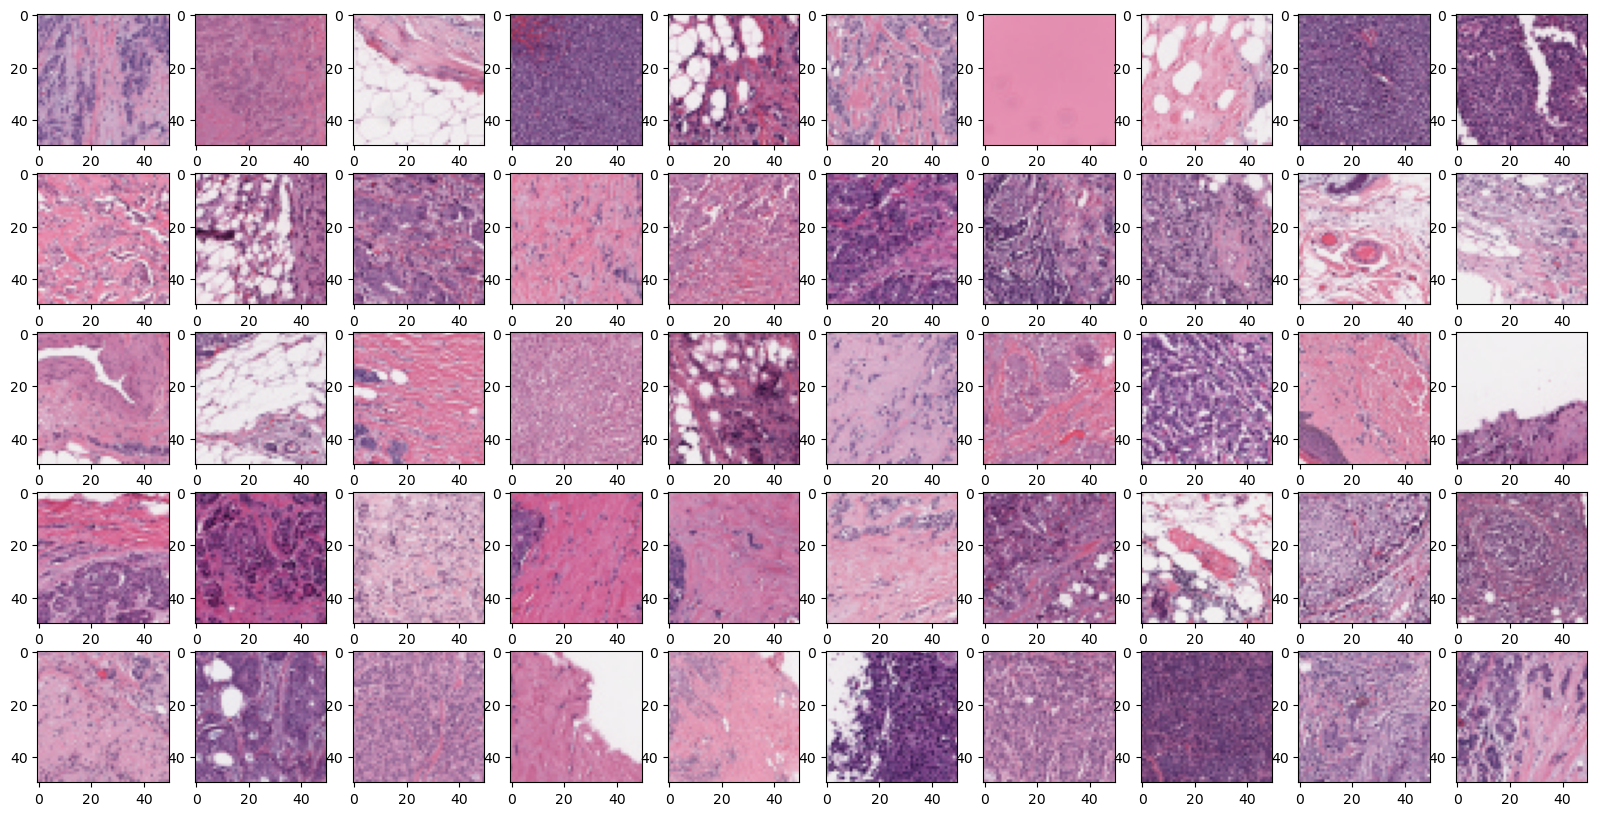

In [14]:
fig, ax = plt.subplots(5,10,figsize=(20,10))

for n in range(5):
    for m in range(10):
        idx = pos_selection[m + 10*n]
        image = imread(data.loc[idx, "path"])
        ax[n,m].imshow(image)
        ax[n,m].grid(False)

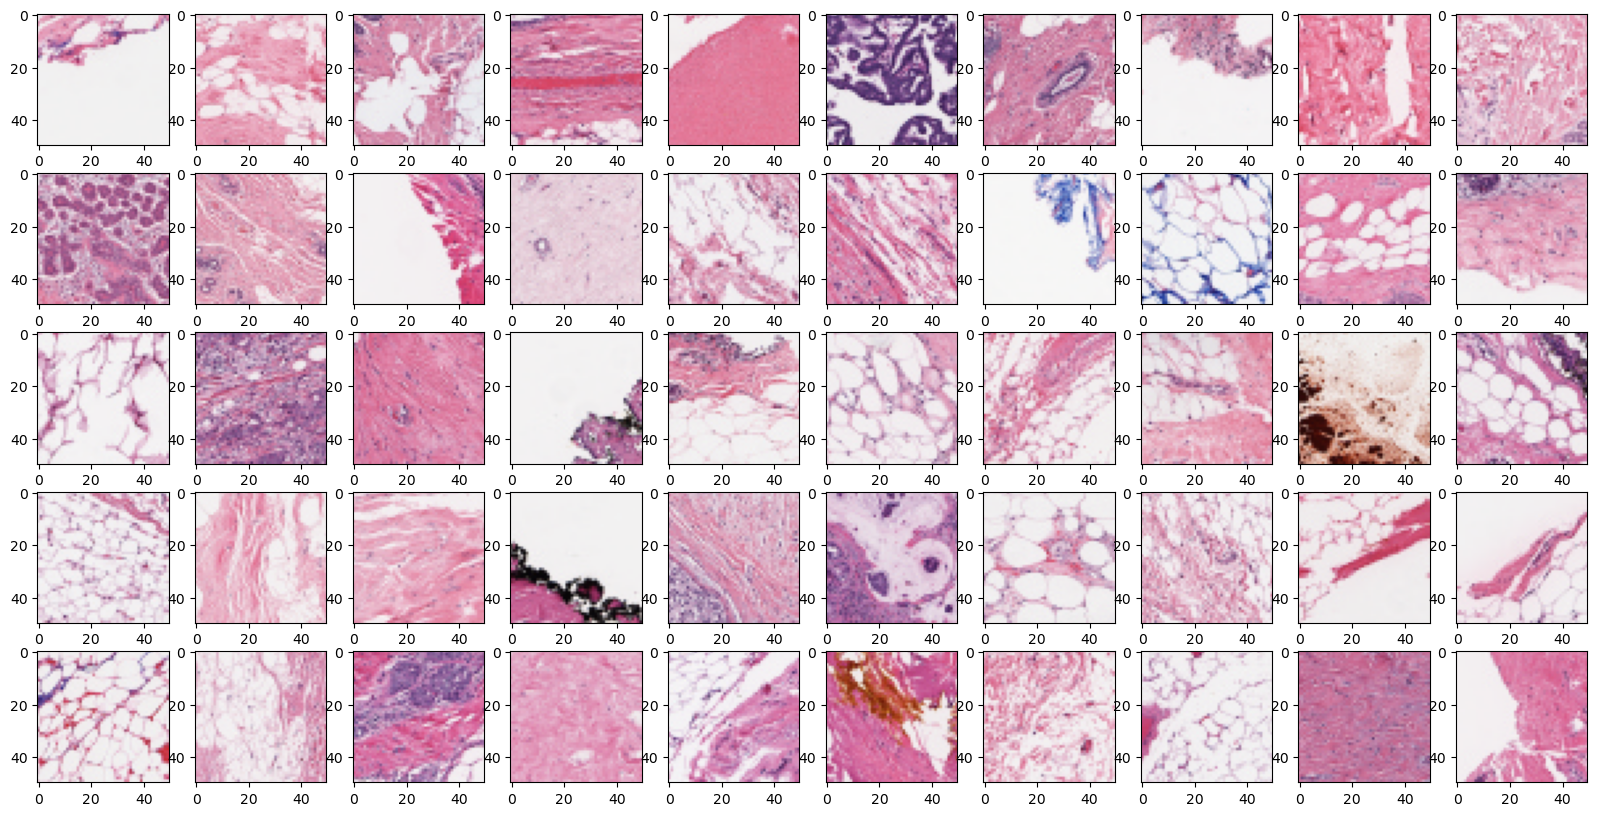

In [15]:
fig, ax = plt.subplots(5,10,figsize=(20,10))

for n in range(5):
    for m in range(10):
        idx = neg_selection[m + 10*n]
        image = imread(data.loc[idx, "path"])
        ax[n,m].imshow(image)
        ax[n,m].grid(False)

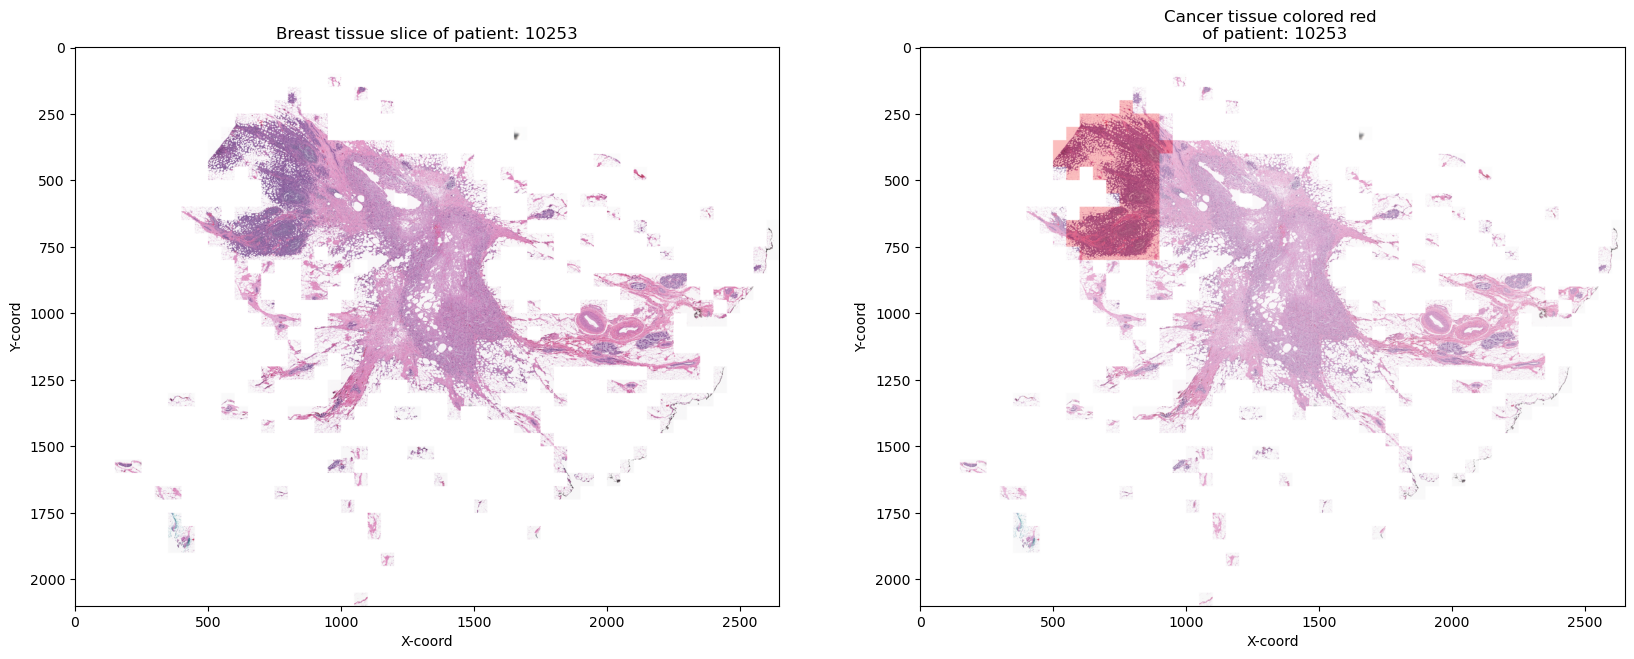

In [33]:
from skimage.io import imread
import numpy as np
import matplotlib.pyplot as plt

# Assuming you have the get_patient_dataframe function defined somewhere
def visualise_breast_tissue_base(patient_id, pred_df=None):
    example_df = get_patient_dataframe(patient_id)

    # Calculate maximum coordinates for the grid
    max_point = [example_df.y.max() - 1, example_df.x.max() - 1]
    
    # Initialize grid, mask, and mask_proba
    grid = 255 * np.ones(shape=(max_point[0] + 50, max_point[1] + 50, 3)).astype(np.uint8)
    mask = 255 * np.ones(shape=(max_point[0] + 50, max_point[1] + 50, 3)).astype(np.uint8)
    mask_proba = np.zeros(shape=(max_point[0] + 50, max_point[1] + 50, 1)).astype(float)

    # If pred_df is provided, filter patient_df based on patient_id
    if pred_df is not None:
        patient_df = pred_df[pred_df.patient_id == patient_id].copy()

    # Initialize a list to keep track of broken patches
    broken_patches = []

    # Iterate through the example_df DataFrame
    for n in range(len(example_df)):
        try:
            image = imread(example_df.path.values[n])
            
            target = example_df.target.values[n]
            x_coord = np.int64(example_df.x.values[n])
            y_coord = np.int64(example_df.y.values[n])

            # Define the region of interest in the grid
            x_start, y_start = x_coord - 1, y_coord - 1
            x_end, y_end = x_start + 50, y_start + 50

            # Update the grid with the image
            grid[y_start:y_end, x_start:x_end] = image

            # If the target is 1, update the mask with a specific color
            if target == 1:
                mask[y_start:y_end, x_start:x_end, 0] = 250
                mask[y_start:y_end, x_start:x_end, 1] = 0
                mask[y_start:y_end, x_start:x_end, 2] = 0

            # If pred_df is provided, update the mask_proba with predicted probability
            if pred_df is not None:
                proba = patient_df[(patient_df.x == x_coord) & (patient_df.y == y_coord)].proba
                mask_proba[y_start:y_end, x_start:x_end, 0] = float(proba)

        except Exception as e:
            broken_patches.append((example_df.path.values[n], str(e)))

    return grid, mask, broken_patches, mask_proba

def visualise_breast_tissue(patient_id):
    grid, mask, broken_patches, _ = visualise_breast_tissue_base(patient_id)

    fig, ax = plt.subplots(1, 2, figsize=(20, 10))
    ax[0].imshow(grid, alpha=0.9)
    ax[1].imshow(mask, alpha=0.8)
    ax[1].imshow(grid, alpha=0.7)
    ax[0].grid(False)
    ax[1].grid(False)
    for m in range(2):
        ax[m].set_xlabel("X-coord")
        ax[m].set_ylabel("Y-coord")
    ax[0].set_title("Breast tissue slice of patient: " + patient_id)
    ax[1].set_title("Cancer tissue colored red \n of patient: " + patient_id);

# Example usage:
patient_id = "10253"
visualise_breast_tissue(patient_id)


In [34]:
def visualise_breast_tissue_binary(patient_id):
        
    fig, ax = plt.subplots(1,1)

    example_df = get_patient_dataframe(patient_id)

    ax.scatter(example_df.x.values, example_df.y.values, c=example_df.target.values, cmap="coolwarm", s=20);
    ax.set_title("Patient " + patient_id)
    ax.set_xlabel("X coord")
    ax.set_ylabel("Y coord")

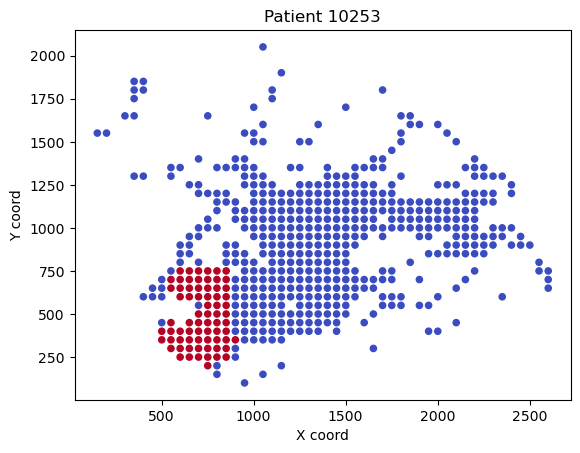

In [35]:
patient_id = "10253"
# get_patient_dataframe(patient_id)
visualise_breast_tissue_binary(patient_id)

In [38]:
#Data preprocessing

data.head()
data.loc[:, "target"] = data.target.astype(str)
data.info()

patients = data.patient_id.unique()

train_ids, sub_test_ids = train_test_split(patients,
                                           test_size=0.3,
                                           random_state=0)
test_ids, dev_ids = train_test_split(sub_test_ids, test_size=0.5, random_state=0)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 277524 entries, 0 to 277523
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   patient_id  277524 non-null  object
 1   path        277524 non-null  object
 2   target      277524 non-null  object
dtypes: object(3)
memory usage: 16.5+ MB


In [39]:
train_df = data.loc[data.patient_id.isin(train_ids),:].copy()
test_df = data.loc[data.patient_id.isin(test_ids),:].copy()
dev_df = data.loc[data.patient_id.isin(dev_ids),:].copy()

train_df = extract_coords(train_df)
test_df = extract_coords(test_df)
dev_df = extract_coords(dev_df)

In [44]:
pip install torch



     -------------------------------------- 192.2/192.2 MB 4.9 MB/s eta 0:00:00


In [45]:
from torch.utils.data import Dataset
from PIL import Image

class BreastCancerDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        patient_id = self.df.patient_id.values[idx]
        x_coord = self.df.x.values[idx]
        y_coord = self.df.y.values[idx]
        image_path = self.df.path.values[idx]

        # Load image
        image = Image.open(image_path)

        # Convert to RGB if not already
        if image.mode != 'RGB':
            image = image.convert('RGB')

        # Apply transformations if provided
        if self.transform:
            image = self.transform(image)

        # Extract target if present
        if "target" in self.df.columns:
            target = int(self.df.target.values[idx])
        else:
            target = None

        return {
            "image": image,
            "label": target,
            "patient_id": patient_id,
            "x": x_coord,
            "y": y_coord
        }


In [46]:
train_dataset = BreastCancerDataset(train_df)
dev_dataset = BreastCancerDataset(dev_df)
test_dataset = BreastCancerDataset(test_df)

In [47]:
image_datasets = {"train": train_dataset, "dev": dev_dataset, "test": test_dataset}
dataset_sizes = {x: len(image_datasets[x]) for x in ["train", "dev", "test"]}

In [48]:
print("Training Dataset : ",dataset_sizes["train"])
print("Dev Dataset : ",dataset_sizes["dev"])
print("Test Dataset : ",dataset_sizes["test"])

Training Dataset :  189156
Dev Dataset :  40747
Test Dataset :  47621


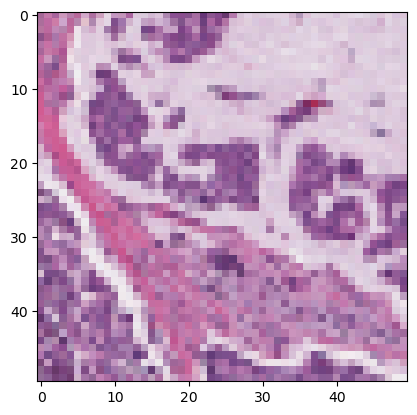

In [49]:
plt.imshow(image_datasets["test"].__getitem__(0)['image'])

In [50]:
#Creating database suitable for tensorflow
train_images = []
train_labels = []
# for i in range(dataset_sizes["train"]):
for i in range(1000):
    train_images.append(np.array(image_datasets["train"].__getitem__(i)['image']))
    train_labels.append(image_datasets["train"].__getitem__(i)['label'])

train_images = np.array(train_images)
train_labels = np.array(train_labels)

In [51]:
train_images.shape

(1000, 50, 50, 3)

In [52]:
#Creating database suitable for tensorflow
test_images = []
test_labels = []
# for i in range(dataset_sizes["test"]):
for i in range(1000,2000):
    test_images.append(np.array(image_datasets["train"].__getitem__(i)['image']))
    test_labels.append(image_datasets["train"].__getitem__(i)['label'])

test_images = np.array(test_images)
test_labels = np.array(test_labels)

In [53]:
test_images.shape

(1000, 50, 50, 3)

In [54]:
#Training
BATCH_SIZE = 32
NUM_CLASSES = 2

from tensorflow.keras import datasets, layers, models

# Normalize pixel values to be between 0 and 1
train_images, test_images = train_images / 255.0, test_images / 255.0

In [55]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(50, 50, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(2))

In [56]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(train_images, train_labels, epochs=10, 
                    validation_data=(test_images, test_labels))


Epoch 1/10


32/32 [==============================] - 3s 53ms/step - loss: 0.2648 - accuracy: 0.9270 - val_loss: 0.3879 - val_accuracy: 0.8330
Epoch 2/10
32/32 [==============================] - 2s 48ms/step - loss: 0.2408 - accuracy: 0.9300 - val_loss: 0.3855 - val_accuracy: 0.8330
Epoch 3/10
32/32 [==============================] - 2s 48ms/step - loss: 0.2220 - accuracy: 0.9300 - val_loss: 0.4261 - val_accuracy: 0.8330
Epoch 4/10
32/32 [==============================] - 2s 49ms/step - loss: 0.2267 - accuracy: 0.9300 - val_loss: 0.3562 - val_accuracy: 0.8330
Epoch 5/10
32/32 [==============================] - 1s 46ms/step - loss: 0.2267 - accuracy: 0.9300 - val_loss: 0.3066 - val_accuracy: 0.8330
Epoch 6/10
32/32 [==============================] - 1s 47ms/step - loss: 0.1930 - accuracy: 0.9300 - val_loss: 0.2960 - val_accuracy: 0.8330
Epoch 7/10
32/32 [==============================] - 2s 48ms/step - loss: 0.1727 - accuracy: 0.9400 - val_loss: 0.4612 - val_accuracy: 0.8330
Epoch 8/10

32/32 - 0s - loss: 0.3033 - accuracy: 0.8720 - 379ms/epoch - 12ms/step


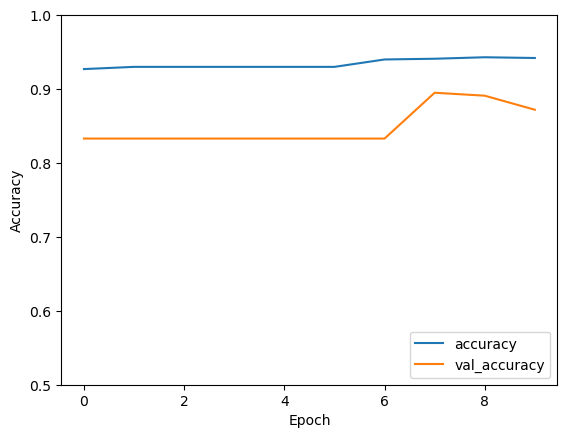

In [57]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)

In [58]:
print(test_acc)

0.871999979019165


In [59]:
def predict_single_image(idx):
    img = []
    img.append(np.array(image_datasets["train"].__getitem__(idx)['image']))
    img = np.array(img)
    print("Cancer : 1","No Cancer : 0")
    print("True Lable : ",image_datasets["train"].__getitem__(idx)['label'])
    print("Predicted Label : ", model.predict(img).argmax(axis=-1)[0])

In [60]:
predict_single_image(25)

Cancer : 1 No Cancer : 0
True Lable :  0
1/1 [==============================] - 0s 152ms/step
Predicted Label :  0
